## Week 10 Homework


### Q1: perform Bayesian Logistic Regression

- For a binary outcome dataset you find interesting (perhaps from kaggle.com?)
- Model the outcome as a bernoulli random variable and use a **logit link** function
- Use `pm.Normal('betas', mu=0, sigma=1, shape=p)` rather than the `pm.MvNormal` version
- Provide inference with Bayesian posterior analysis and report MCMC diagnostics

Output()

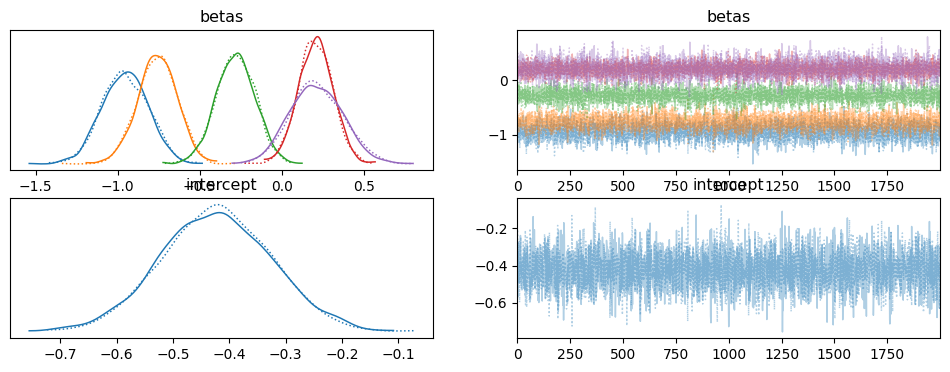

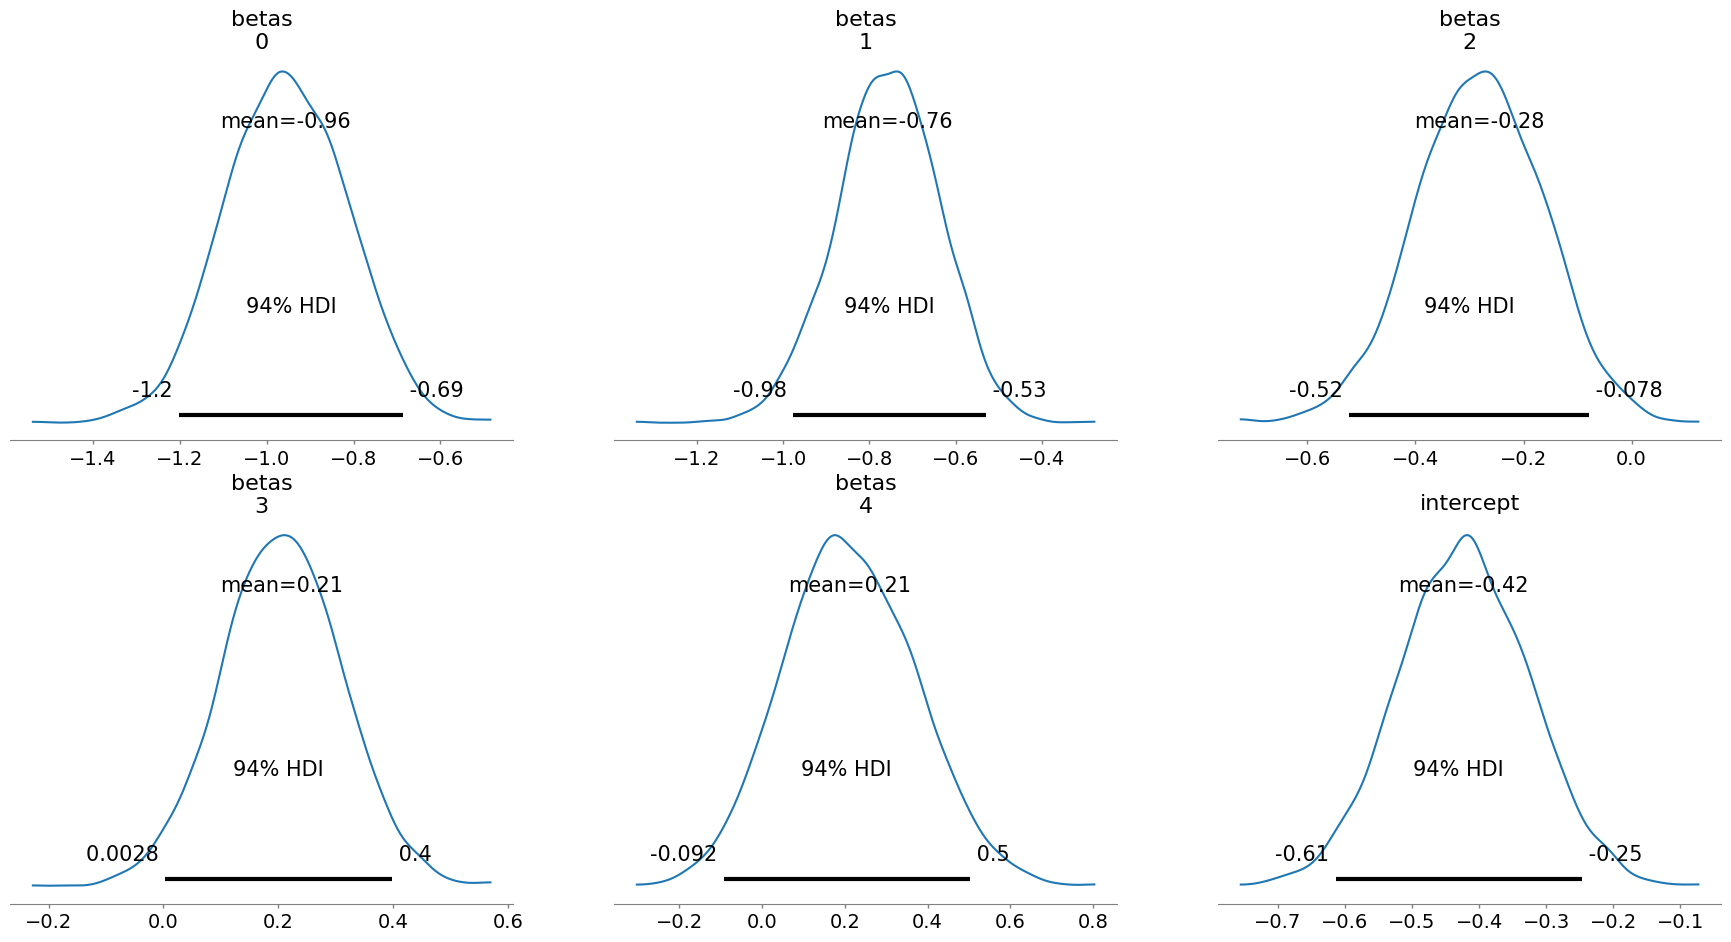

betas HDI: [[-1.20240749 -0.68634061]
 [-0.97709626 -0.52945157]
 [-0.52284252 -0.07817937]
 [ 0.00282604  0.39761787]
 [-0.09236537  0.50147474]]
intercept HDI: [-0.61391901 -0.24710304]


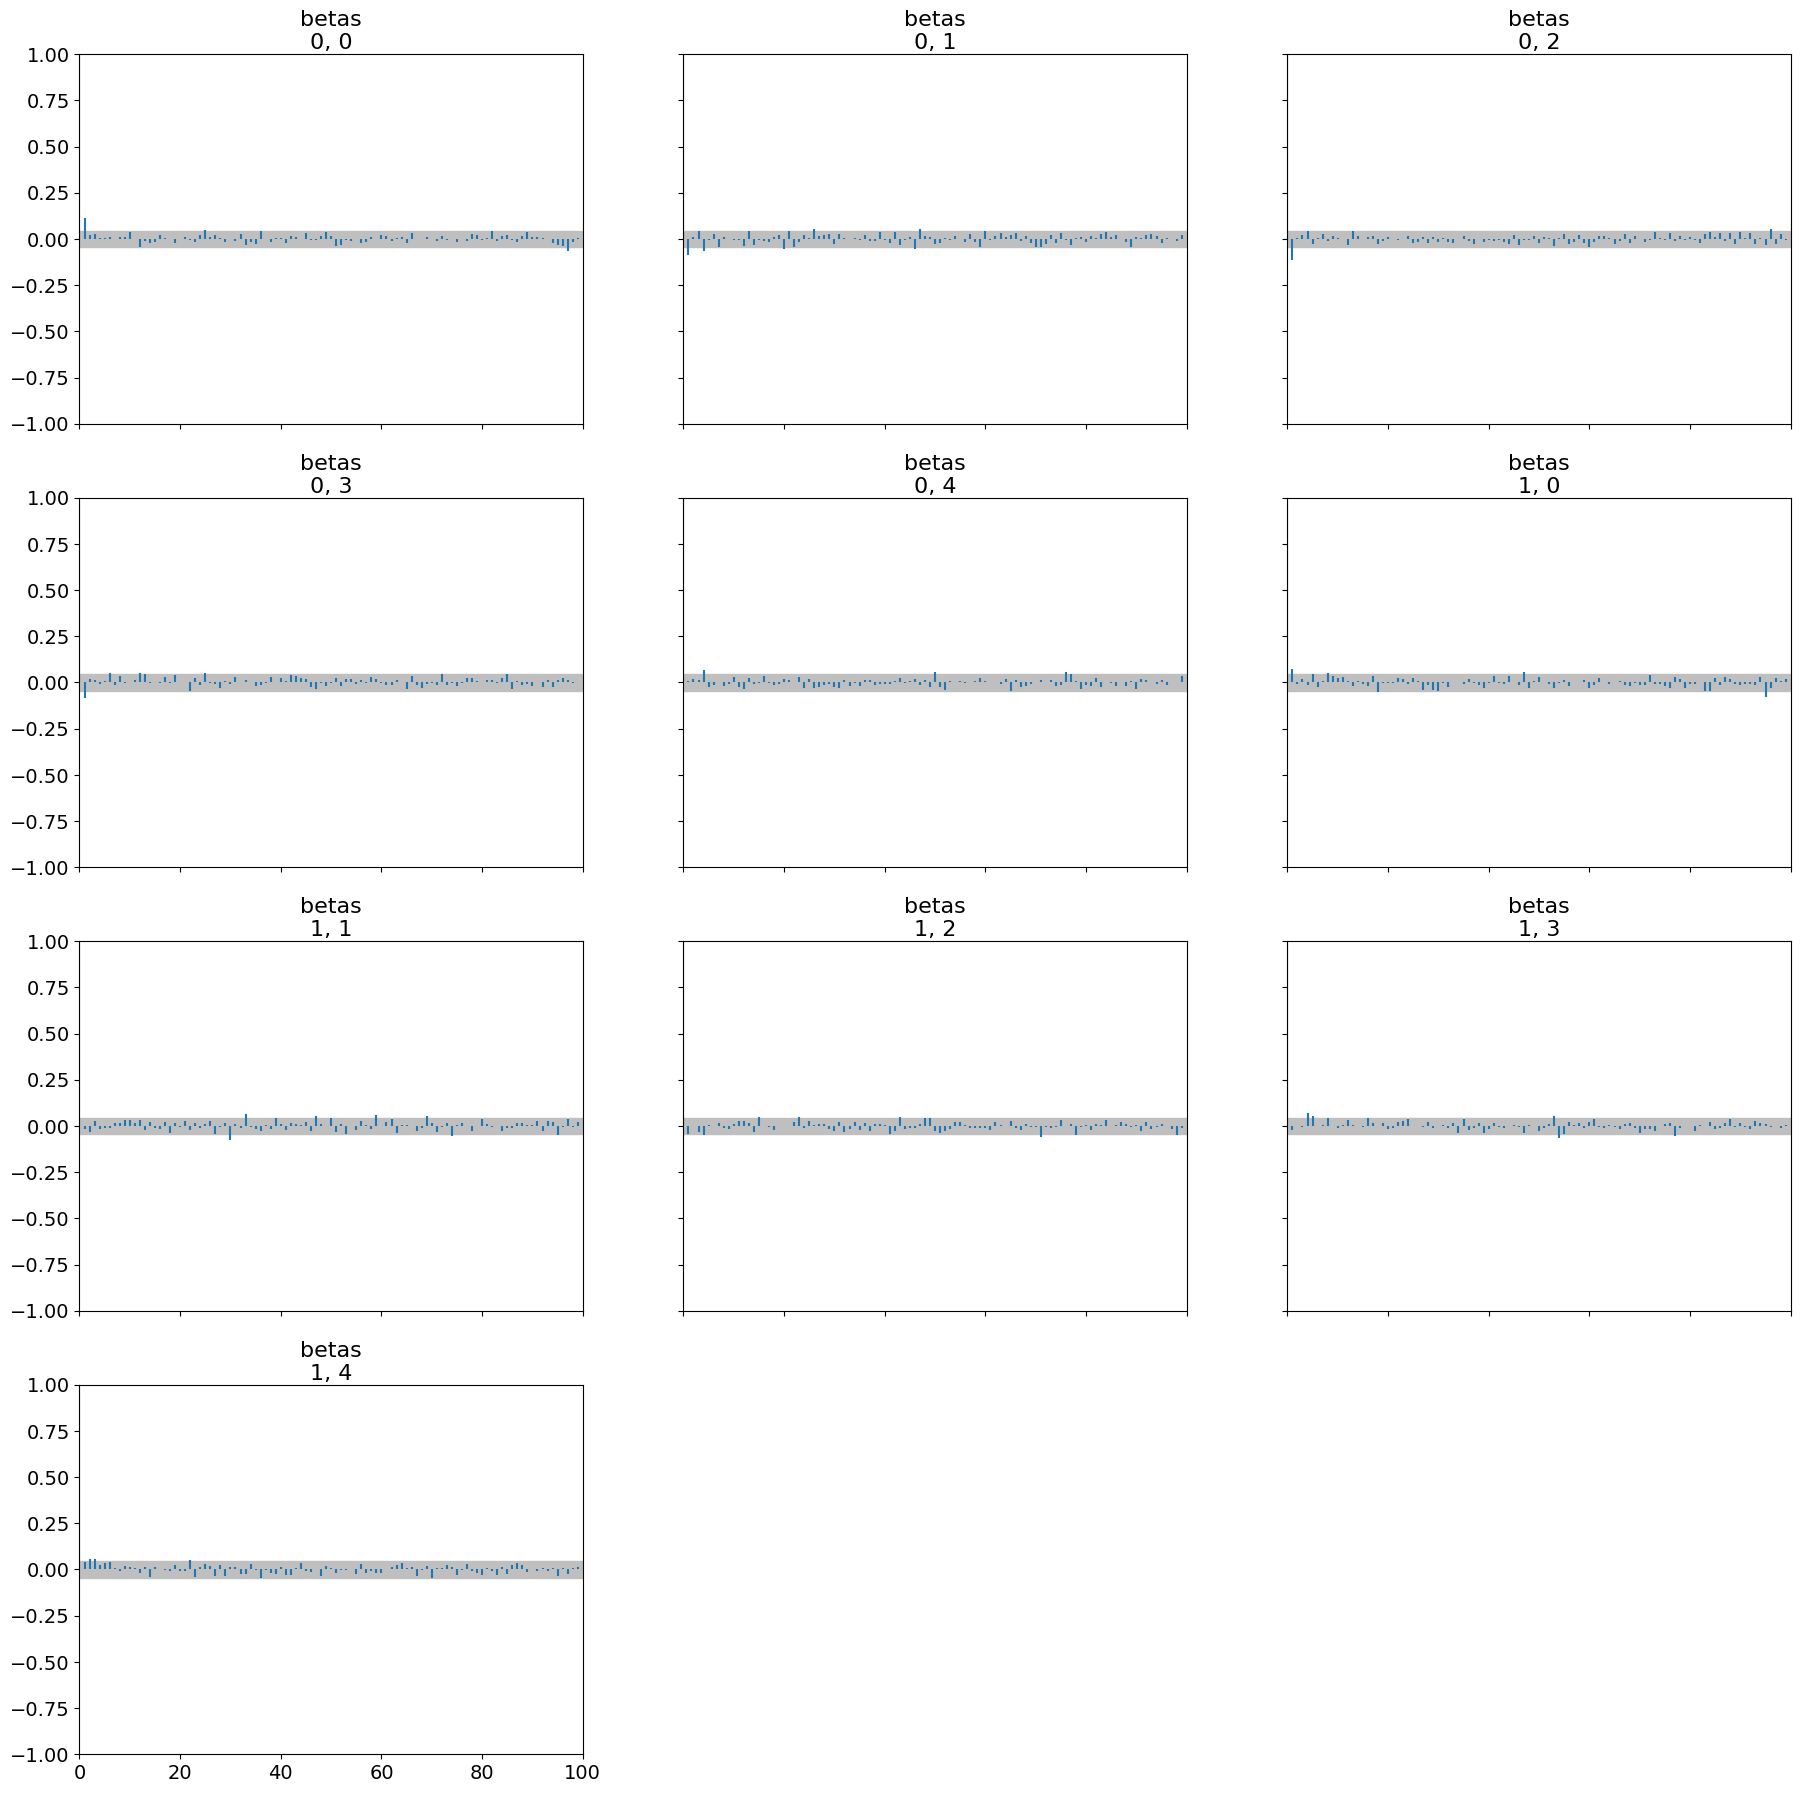

R-hat values:
<xarray.Dataset> Size: 88B
Dimensions:      (betas_dim_0: 5)
Coordinates:
  * betas_dim_0  (betas_dim_0) int64 40B 0 1 2 3 4
Data variables:
    betas        (betas_dim_0) float64 40B 1.0 0.9998 0.9999 1.001 1.0
    intercept    float64 8B 1.001


In [56]:
# Q1 Answer

import numpy as np
import pandas as pd
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Load Dataset
url = "https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv"
data = pd.read_csv(url)

features = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']
data = data[features + ['Survived']].dropna()  # Drop rows with missing values

scaler = StandardScaler()
X = scaler.fit_transform(data[features])
y = data['Survived'].values  # Binary outcome (0 = No, 1 = Yes)

# Split Dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

with pm.Model() as logistic_model:
    # Prior Distribution
    p = X_train.shape[1]
    betas = pm.Normal('betas', mu=0, sigma=1, shape=p)
    intercept = pm.Normal('intercept', mu=0, sigma=1)

    # Link Function
    logit_p = intercept + pm.math.dot(X_train, betas)
    p_survival = pm.math.sigmoid(logit_p)  # Logit link function

    # Likelihood
    y_obs = pm.Bernoulli('y_obs', p=p_survival, observed=y_train)

    # Bayesian Inference
    trace = pm.sample(2000, tune=1000, return_inferencedata=True, target_accept=0.9)

# Posterior Analysis
az.plot_trace(trace)
plt.show()

az.plot_posterior(trace)
plt.show()

hdi_credible_intervals = az.hdi(trace, hdi_prob=0.94)  # 94% HDI
for param, hdi_values in hdi_credible_intervals.items():
    print(f"{param} HDI: {hdi_values.values}")

# MCMC Diagnostics
az.plot_autocorr(trace, var_names=['betas'])
plt.show()

print("R-hat values:")
print(az.rhat(trace))

### Q2: perform Bayesian Multivariate Regression

- For a data set for which modeling multiple continuous outcomes might be interesting (perhaps from kaggle.com?)
- Use `pm.Normal('betas', mu=0, sigma=1, shape=(p,m))` rather than a `pm.MvNormal` alternative
- Use `y = pm.MvNormal('y', mu=X@betas, chol=L, observed=x)` for `(n,m)` shaped `y` and `(n,p)` shaped `X`
- Downsample your dataset to tentatively explore the effect of different values of `n`,`m`,`p` and
    - report on your findings and based on that
    - choose a "reasonably small" sized data set to perform an actual analysis
- Provide inference with Bayesian posterior analysis and report MCMC diagnostics


In [57]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [58]:
import pandas as pd
data = pd.read_csv('/content/drive/My Drive/nbaplayers1718.csv')

Output()

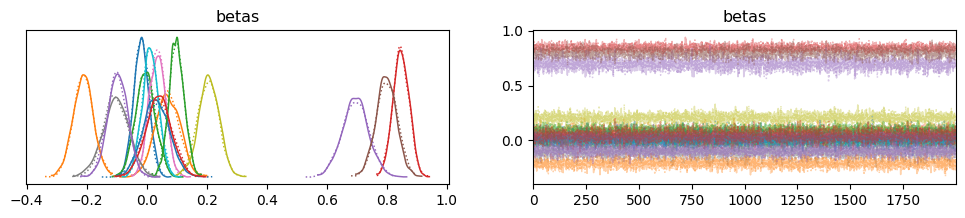

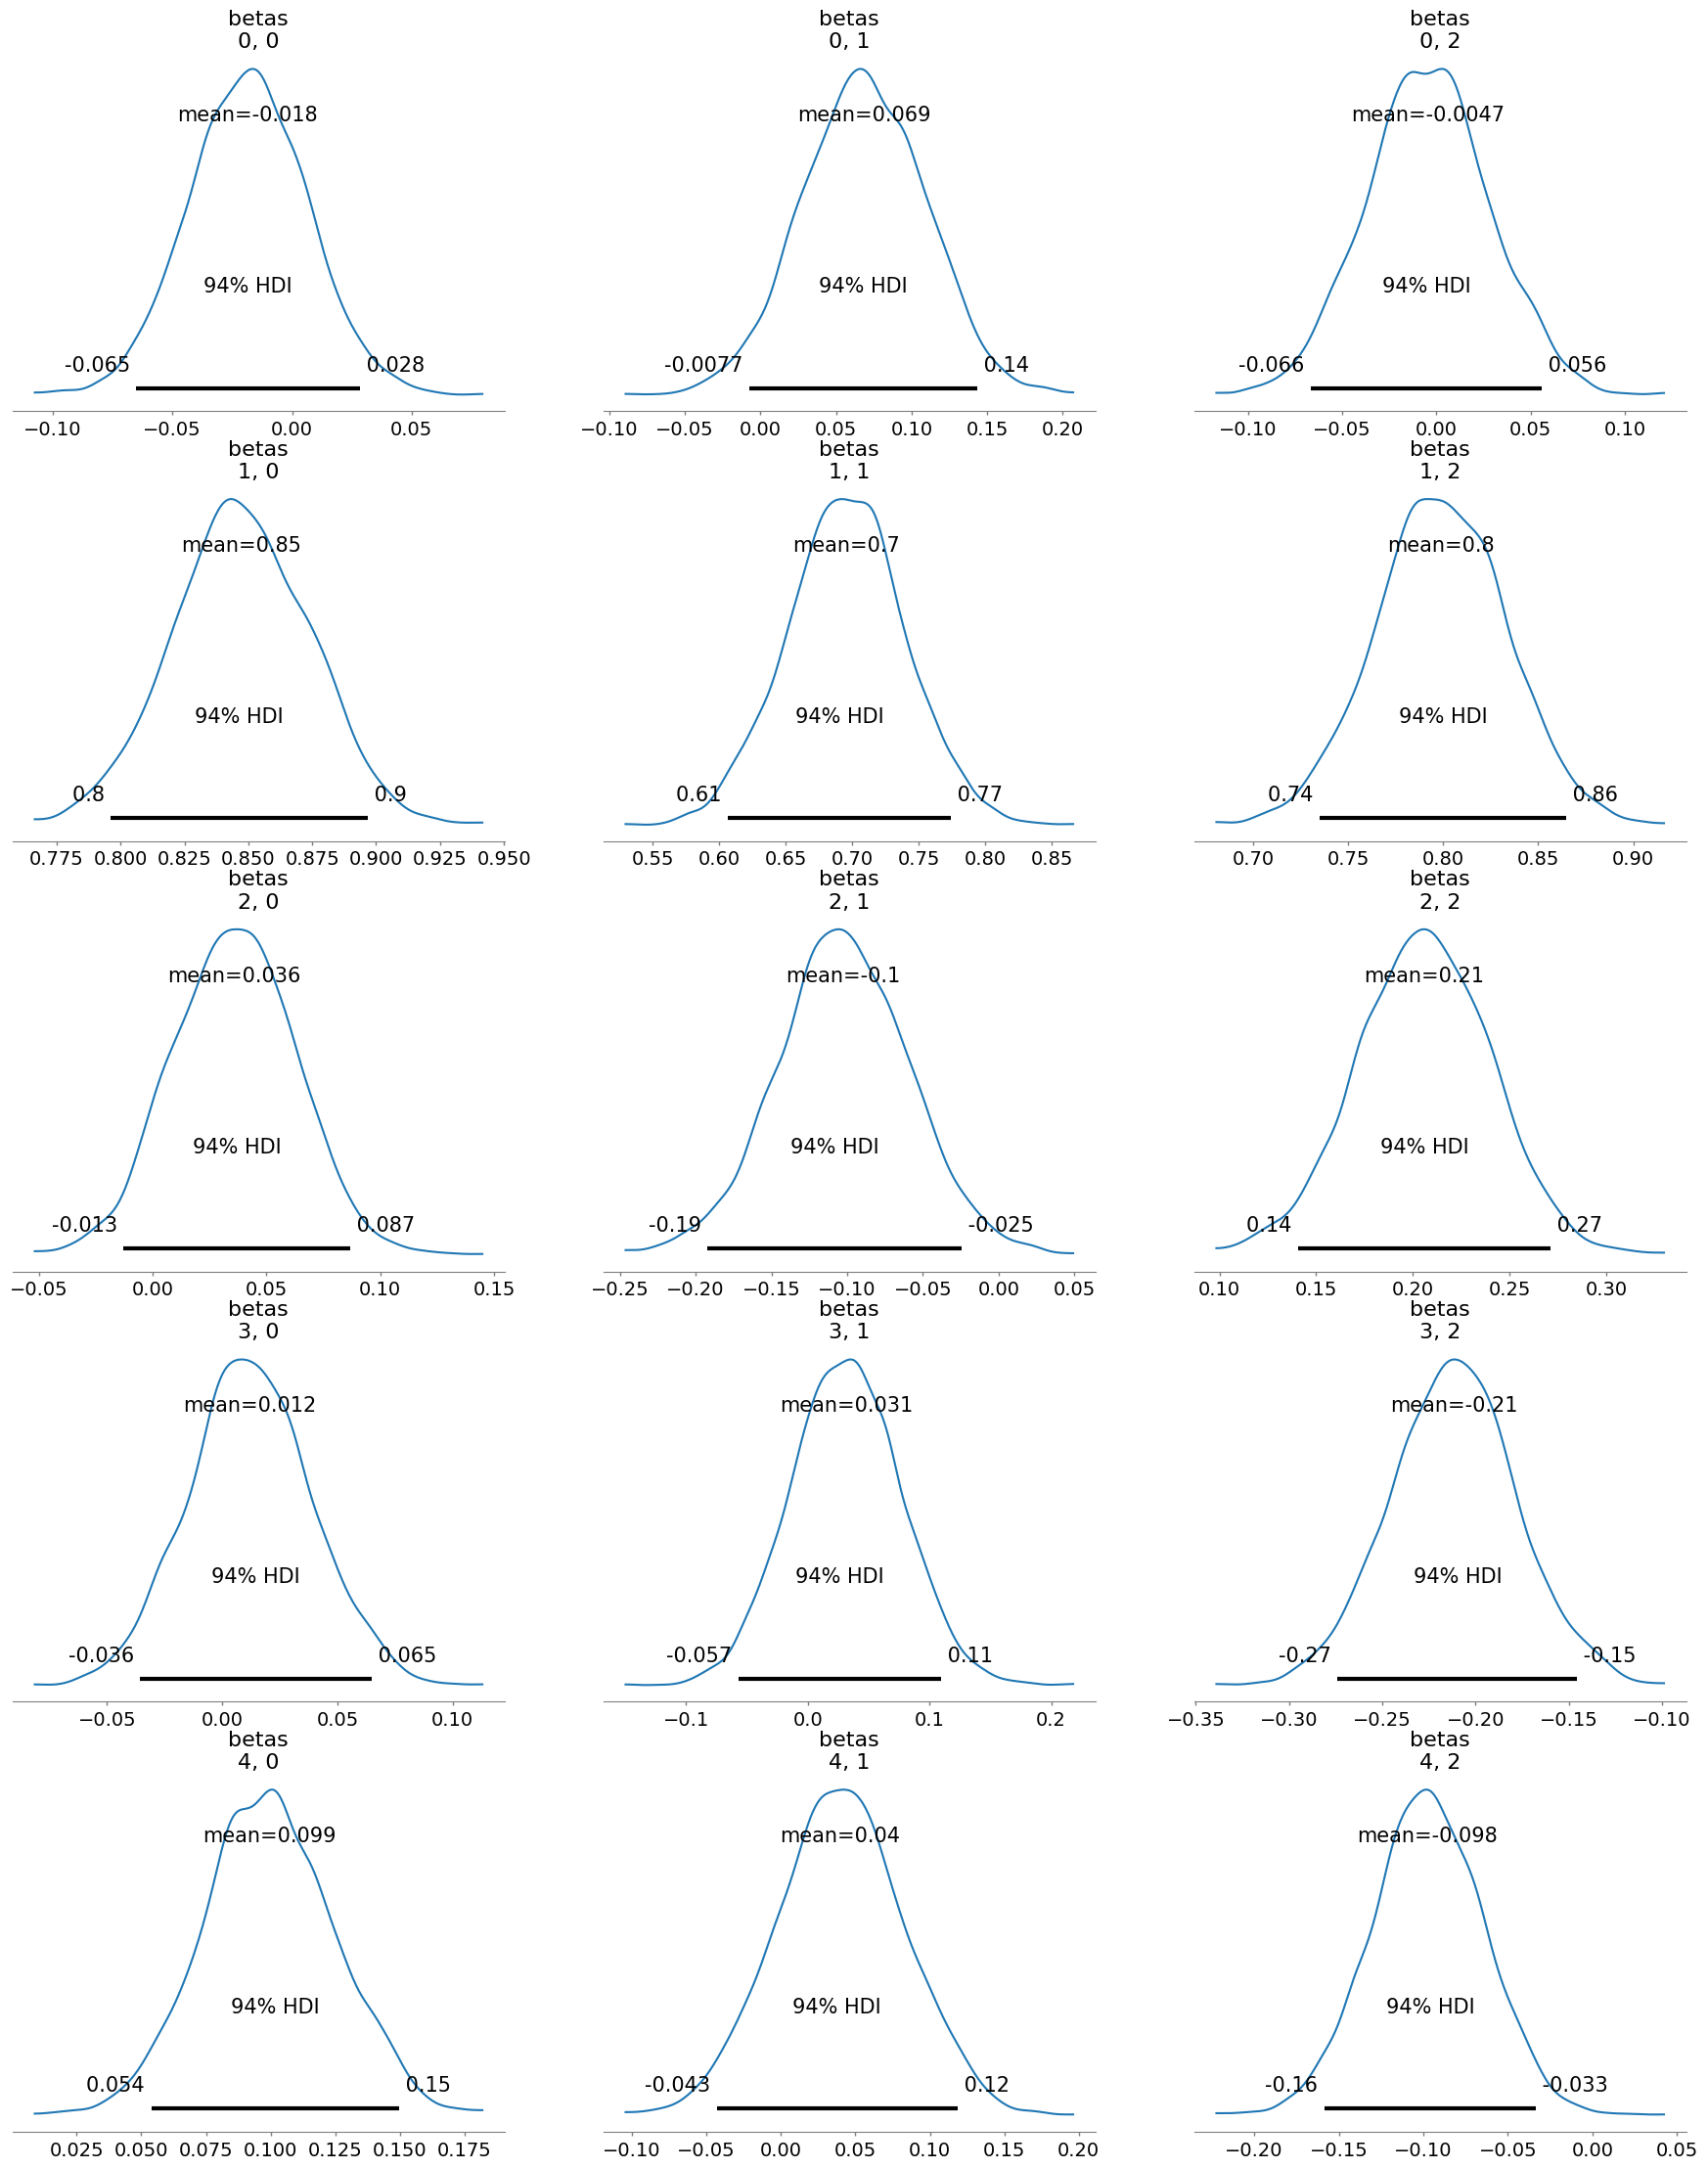

Sigma HDI: [[[ 0.17373066  0.23044117]
  [ 0.08381196  0.15785197]
  [ 0.0158092   0.07115463]]

 [[ 0.08381196  0.15785197]
  [ 0.48468797  0.63887108]
  [-0.11421479 -0.0260329 ]]

 [[ 0.0158092   0.07115463]
  [-0.11421479 -0.0260329 ]
  [ 0.30384647  0.40288826]]]
betas HDI: [[[-0.06503704  0.02822745]
  [-0.00766601  0.14365573]
  [-0.06634183  0.05597551]]

 [[ 0.79626851  0.89676563]
  [ 0.60630452  0.77378895]
  [ 0.7350841   0.86454801]]

 [[-0.01279585  0.08678318]
  [-0.19217805 -0.02468741]
  [ 0.14067568  0.27134171]]

 [[-0.0355908   0.06486575]
  [-0.05733687  0.10970108]
  [-0.27395298 -0.14538588]]

 [[ 0.05387668  0.14960528]
  [-0.04313262  0.11852848]
  [-0.15846032 -0.03325052]]]
packed_L HDI: [[ 0.41774484  0.48097497]
 [ 0.19570097  0.34460231]
 [ 0.64944524  0.74467795]
 [ 0.03448089  0.15469879]
 [-0.19255477 -0.07723937]
 [ 0.52917125  0.60927266]]


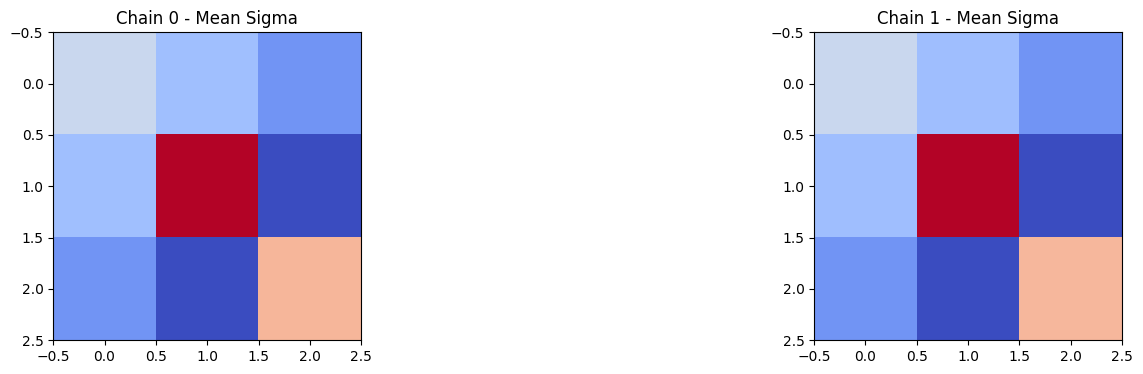

In [59]:
# Q2 Answer

import numpy as np
import pandas as pd
import pymc as pm
import arviz as az
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Initialize Data
y_cols = ["PTS", "AST", "TRB"]
x_cols = ["Age", "MP", "FG%", "3P%", "FT%"]

data = data.dropna(subset=y_cols + x_cols)
Y = data[y_cols].values
X = data[x_cols].values

scaler_x = StandardScaler()
scaler_y = StandardScaler()
X = scaler_x.fit_transform(X)
Y = scaler_y.fit_transform(Y)

# Split Dataset
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

n, p = X_train.shape
m = Y_train.shape[1]
with pm.Model() as multivariate_regression:
    # Cholesky Decomposition for Covariance
    packed_L = pm.LKJCholeskyCov("packed_L", n=m, eta=2.0,
                                 sd_dist=pm.Exponential.dist(1.0, shape=m),
                                 compute_corr=False)
    L = pm.expand_packed_triangular(m, packed_L)

    # Prior Distributions
    betas = pm.Normal("betas", mu=0, sigma=1, shape=(p, m))

    # Covariance Matrix
    Sigma = pm.Deterministic("Sigma", L.dot(L.T))

    # Likelihood
    y_obs = pm.MvNormal("y", mu=X_train @ betas, chol=L, observed=Y_train)

    # Bayesian Inference
    trace = pm.sample(2000, tune=1000, target_accept=0.9, return_inferencedata=True)

# Step 4: Posterior Analysis
az.plot_trace(trace, var_names=['betas'])
plt.show()

az.plot_posterior(trace, var_names=['betas'])
plt.show()

hdi_credible_intervals = az.hdi(trace, hdi_prob=0.94)
for param, hdi_values in hdi_credible_intervals.items():
    print(f"{param} HDI: {hdi_values.values}")

fig, ax = plt.subplots(1, 2, figsize=(18, 4))

for chain in range(2):
    ax[chain].imshow(trace.posterior["Sigma"].mean(axis=1)[chain], cmap="coolwarm")
    ax[chain].set_title(f"Chain {chain} - Mean Sigma")

plt.show()

### Q3: perform Bayesian Multivariate Classification

- For a data set for which modeling multiple binary outcomes might be interesting (perhaps from kaggle.com?)
- Use `pm.Normal('betas', mu=0, sigma=1, shape=(p,m))` rather than a `pm.MvNormal` alternative
- Use `y = pm.Bernoulli('y', p=pm.math.invprobit(X@betas), observed=x)` for `(n,m)` shaped `y` and `(n,p)` shaped `X`
- Use latent `z = pm.MvNormal('z', mu=X@betas, chol=L)` as discussed in the "Generalized Linear Models (GLM)" section of the previous weeks lecture notes

> This provides normally distributed latent variables connected to the observed binary outcomes on which a latent covariance dependency structure may be modelled and estimated on the basis of imputing the unobserved latent variables based on their connection with the observed binary outcome variables.

- Downsample your dataset to tentatively explore the effect of different values of `n`,`m`,`p` and
    - report on your findings and based on that
    - choose a "reasonably small" sized data set to perform an actual analysis
- Provide inference with Bayesian posterior analysis and report MCMC diagnostics


In [61]:
data = pd.read_csv('/content/drive/My Drive/heart.csv')

Output()

ERROR:pymc.stats.convergence:There were 1505 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


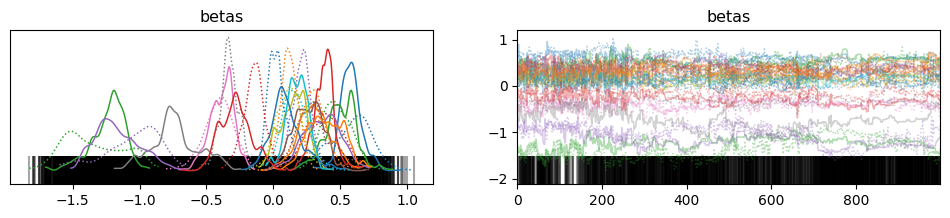

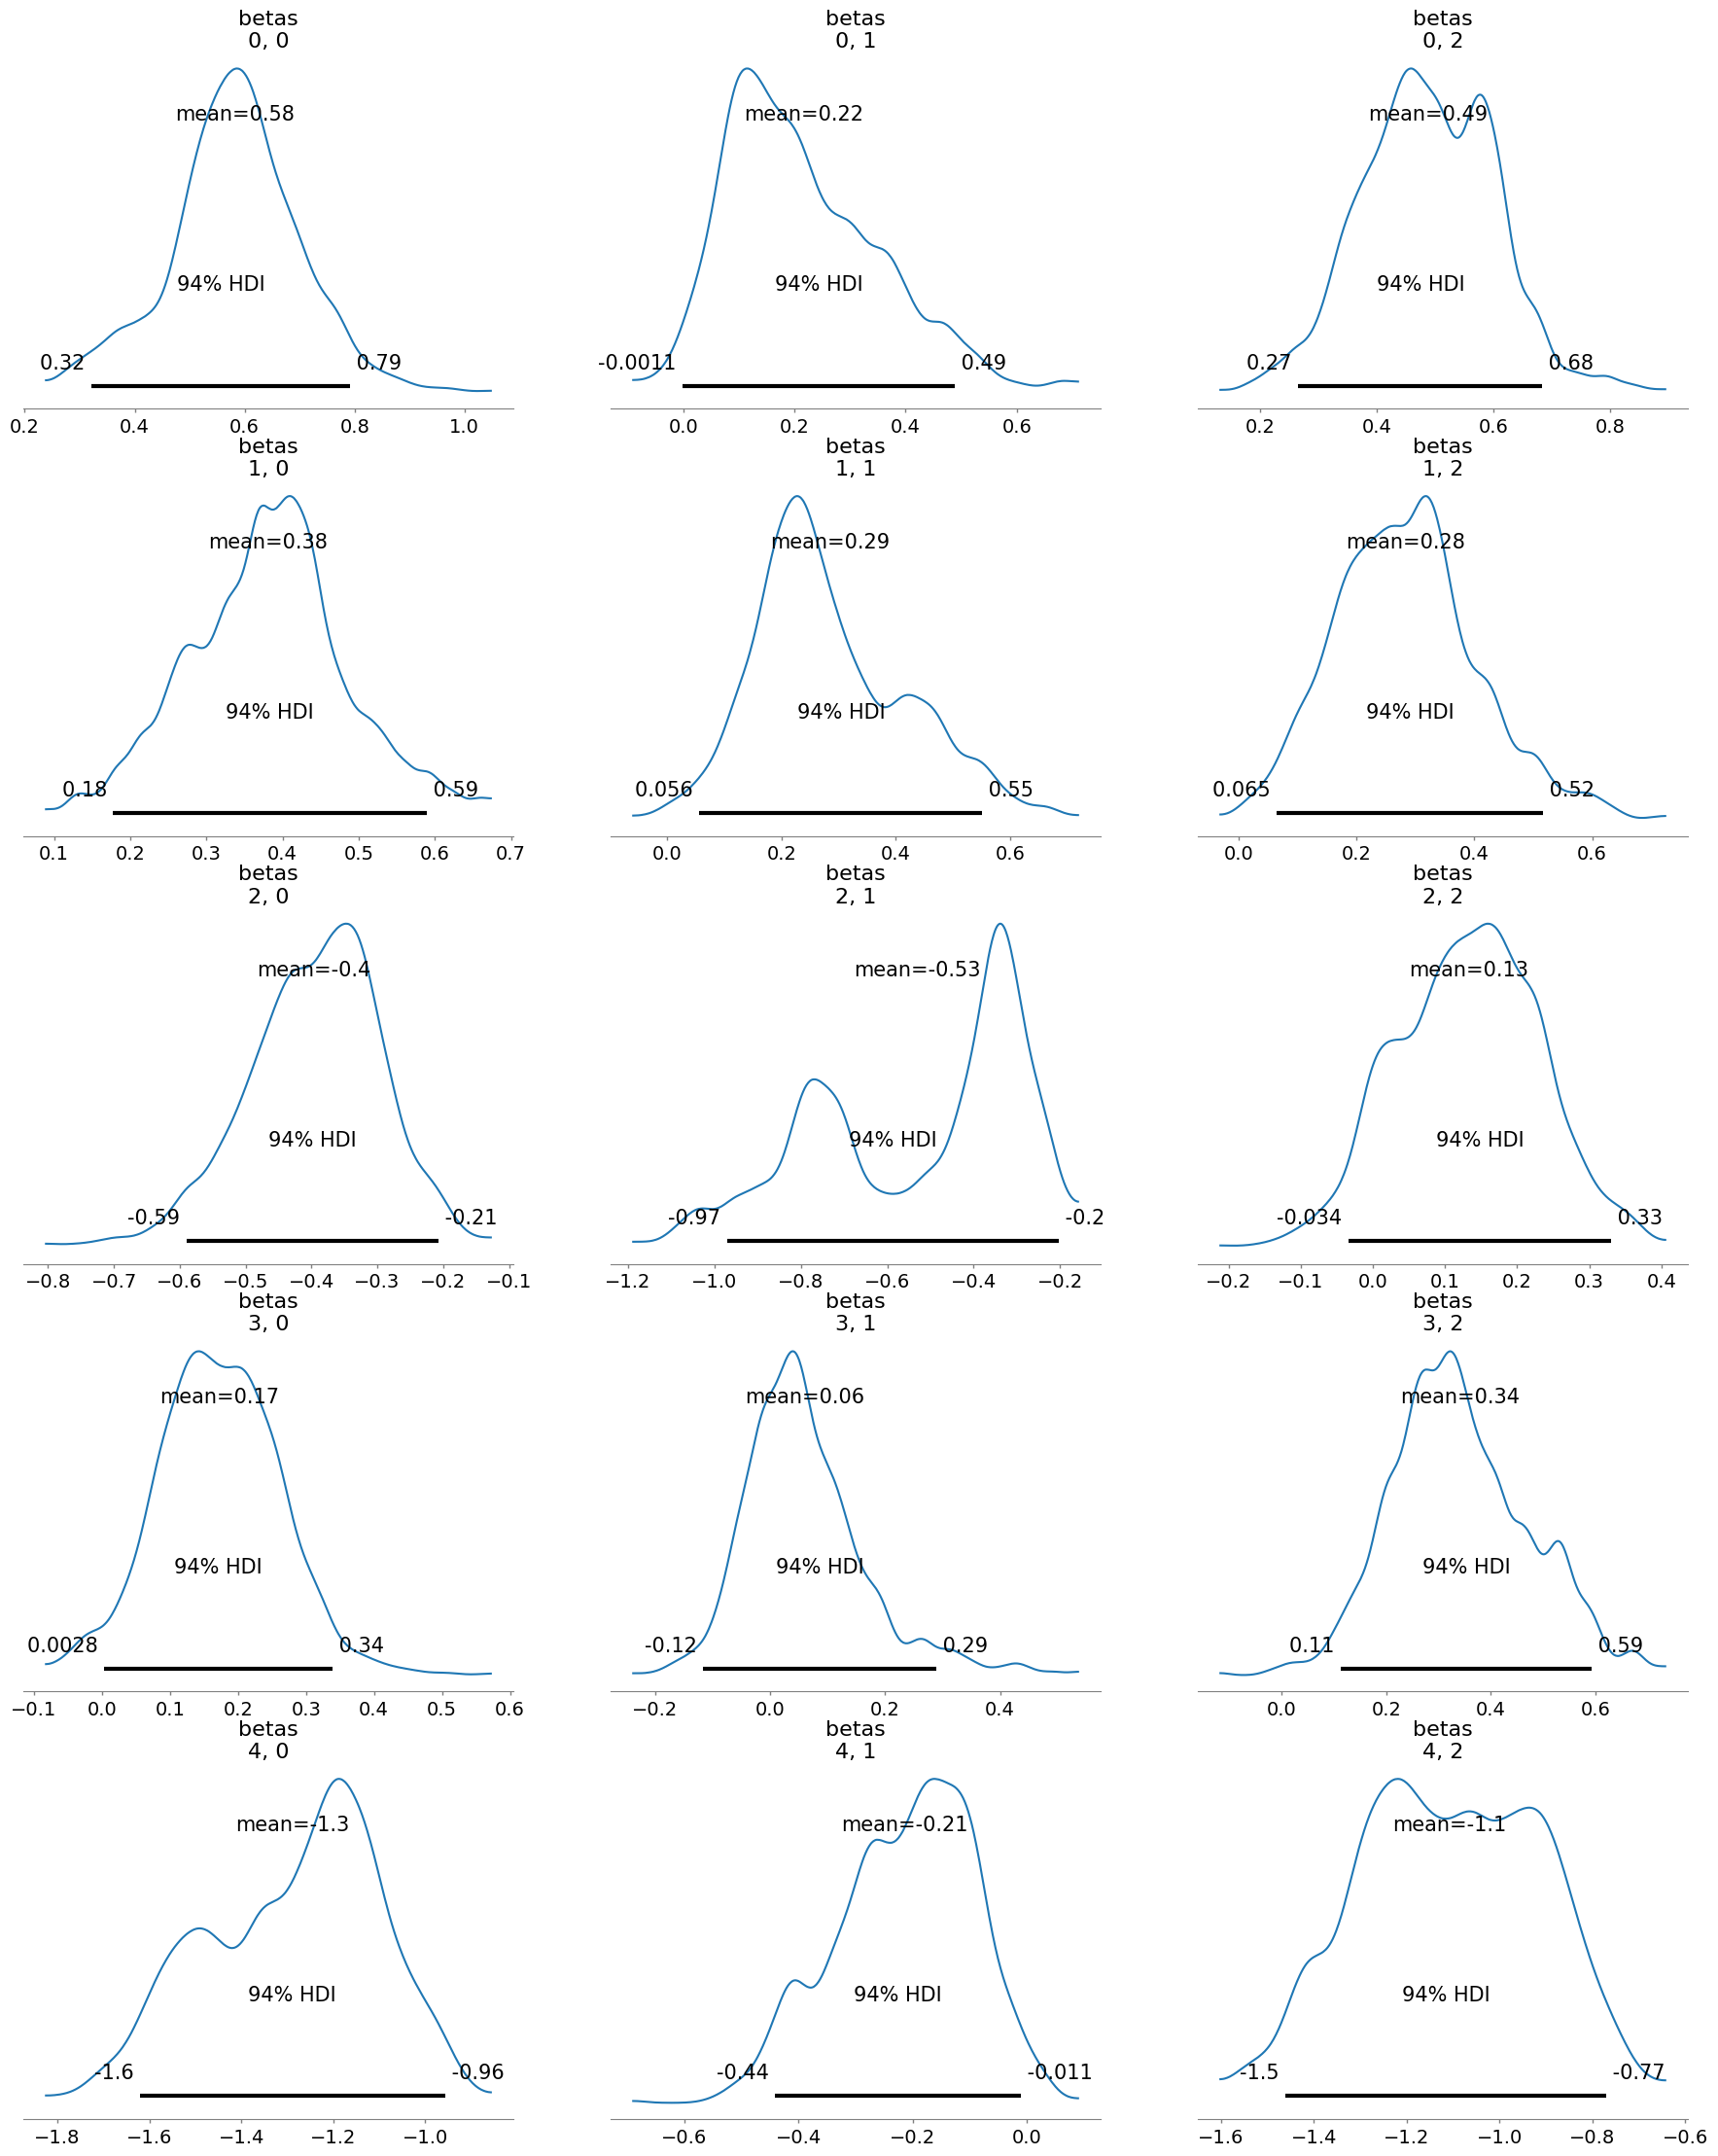

betas HDI: [[[ 3.21365368e-01  7.91584969e-01]
  [-1.06963144e-03  4.88078267e-01]
  [ 2.65950919e-01  6.83495852e-01]]

 [[ 1.77667483e-01  5.89135274e-01]
  [ 5.64648046e-02  5.51793384e-01]
  [ 6.47962349e-02  5.16794620e-01]]

 [[-5.89472641e-01 -2.07578754e-01]
  [-9.70928105e-01 -2.02832523e-01]
  [-3.35627055e-02  3.29815712e-01]]

 [[ 2.79109615e-03  3.38929799e-01]
  [-1.16350370e-01  2.89515563e-01]
  [ 1.12574469e-01  5.93400835e-01]]

 [[-1.62066895e+00 -9.57381845e-01]
  [-4.40977242e-01 -1.10164435e-02]
  [-1.46103203e+00 -7.70685698e-01]]]
packed_L HDI: [[ 0.85724325  1.78985666]
 [-0.20190822  0.7678486 ]
 [ 0.58404571  3.15642336]
 [ 0.89033343  1.82778313]
 [-0.13179548  0.58881177]
 [ 0.6731147   1.6196392 ]]
z HDI: [[[-1.34596376  1.62554157]
  [-1.40810116  4.44489382]
  [-2.65948264  1.45077553]]

 [[-4.53325075 -0.11186995]
  [-6.17572398  0.81595216]
  [-4.51138725  0.4386076 ]]

 [[-0.21631234  4.19280835]
  [-0.72019524  5.67945379]
  [-0.74139368  5.18962223]

In [62]:
# Q3 Answer

import numpy as np
import pandas as pd
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

# Converting categorical binary variables to numeric (0,1)
data["Sex"] = (data["Sex"] == "M").astype(int)
data["ExerciseAngina"] = (data["ExerciseAngina"] == "Y").astype(int)
data["ST_Slope"] = data["ST_Slope"].map({"Up": 2, "Flat": 1, "Down": 0})

y_cols = ["HeartDisease", "FastingBS", "ExerciseAngina"]
categorical_features = ["Sex"]
numerical_features = ["Age", "Cholesterol", "RestingBP", "ST_Slope"]

encoder = OneHotEncoder(drop="first", handle_unknown="ignore")
X_categorical = encoder.fit_transform(data[categorical_features]).toarray()

# Extract numerical features
X_numerical = data[numerical_features].values

# Combine categorical & numerical features
X = np.hstack((X_categorical, X_numerical))
Y = data[y_cols].values.astype(int)  # Ensure binary outcomes are integers

# Standardizing predictors
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split Dataset
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

n, p = X_train.shape
m = Y_train.shape[1]
with pm.Model() as multivariate_classification:
    # Cholesky Decomposition for Covariance
    packed_L = pm.LKJCholeskyCov("packed_L", n=m, eta=2.0,
                                 sd_dist=pm.Exponential.dist(1.0, shape=m),
                                 compute_corr=False)
    L = pm.expand_packed_triangular(m, packed_L)

    # Prior Distributions
    betas = pm.Normal("betas", mu=0, sigma=1, shape=(p, m))

    # Latent Variables
    z = pm.MvNormal("z", mu=X_train @ betas, chol=L, shape=(n, m))

    # Likelihood
    y_obs = pm.Bernoulli("y", p=pm.math.invprobit(z), observed=Y_train)  # ✅ Y_train is now integer

    # Bayesian Inference
    trace = pm.sample(1000, tune=500, target_accept=0.95, cores=1, chains=2, return_inferencedata=True)

# Posterior Analysis
az.plot_trace(trace, var_names=['betas'])
plt.show()

az.plot_posterior(trace, var_names=['betas'])
plt.show()

# HDIs for parameters
hdi_credible_intervals = az.hdi(trace, hdi_prob=0.94)
for param, hdi_values in hdi_credible_intervals.items():
    print(f"{param} HDI: {hdi_values.values}")

plt.show()

References: used OpenAI to generate sections of code.